In [6]:
import os
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imageio.v3 as imageio


import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

from torchvision import transforms

In [29]:
def carica_img(img_path):
    # Carico l'immagine
    img = Image.open(img_path).convert("RGB")
    # Trasformo l'immagine in tensore (C,H,W)
    transform = transforms.ToTensor()
    img_tensor = transform(img)
    # Il modello vuole una lista di immagini
    return [img_tensor]

In [39]:
# Classe COCO (80 categorie)
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant','', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe','', 'backpack', 'umbrella','','',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle','', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed','', 'dining table','','', 'toilet','', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator','', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

def visualizza_pred(x, prediction, score_thresh=0.5):
    img_tensor = x[0]
    pred = prediction[0]

    boxes = pred['boxes'].cpu().numpy()
    labels = pred['labels'].cpu().numpy()
    scores = pred['scores'].cpu().numpy()

    # Da tensor (C,H,W) → array (H,W,C)
    img = img_tensor.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(img)
    ax.axis("off")

    for box, label, score in zip(boxes, labels, scores):
        if score < score_thresh:
            continue

        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1

        rect = patches.Rectangle((x1, y1), w, h,
                                 linewidth=2, edgecolor='lime',
                                 facecolor='none')
        ax.add_patch(rect)

        class_name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f"id:{label}"
        
        ax.text(x1, y1 - 5,
                f"{class_name} {score:.2f}",
                color="yellow",
                fontsize=10,
                bbox=dict(facecolor='black', alpha=0.5))

    plt.show()

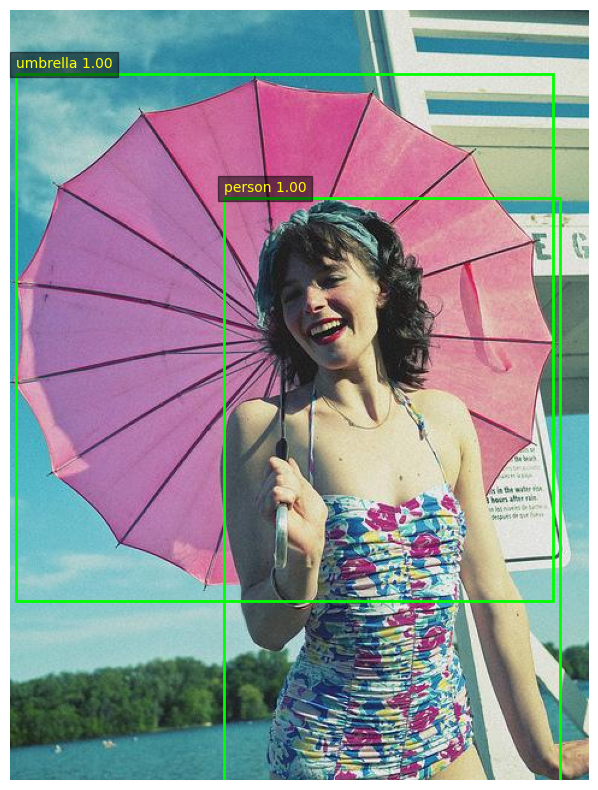

In [40]:
"""
https://docs.pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
"""
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
# For training
# in input la rete prende
# 1. lista di immagini, ovvero lista di N tensori (3,H,W)
# 2. lista di dizionari, ovvero lista di N dizionari (uno per immagine)
# e ogni dizionario alla voce 'boxes' ha un tensore (M,4), dove M è il num di obj in una img,
# e alla voce 'labels' ha un tensore (M,1) ovvero (M,) che indica la classe del box
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)
output = model(images, targets)
# in output la rete da dizionario di loss (una voce per ogni loss usata)
# For inference
# in input la rete prende solo la lista di immagini
model.eval()
#x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
x = [torch.rand(3, 300, 400)]
x = carica_img("/kaggle/input/cococustom/kaggle/working/train/000000000036.jpg")
with torch.no_grad():
    predictions = model(x)
# in output la rete da lista di dict con voci 'boxes' e 'lables'
visualizza_pred(x, predictions, score_thresh=0.6)

# optionally, if you want to export the model to ONNX:
#torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

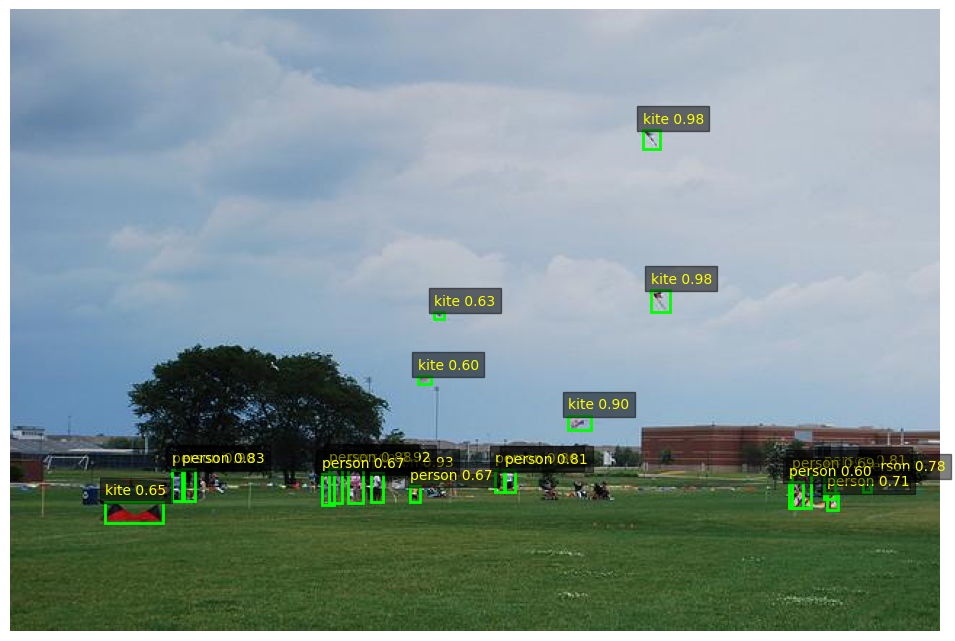

In [41]:
# model.eval()
#x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
x = [torch.rand(3, 300, 400)]
x = carica_img("/kaggle/input/cococustom/kaggle/working/train/000000000149.jpg")
with torch.no_grad():
    predictions = model(x)
# in output la rete da lista di dict con voci 'boxes' e 'lables'
visualizza_pred(x, predictions, score_thresh=0.6)

# optionally, if you want to export the model to ONNX:
#torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

80
{'boxes': tensor([[  0.0000,  50.1200, 475.7589, 480.4700],
        [174.1996, 162.8900, 497.0790, 628.0800]]), 'labels': tensor([28,  1]), 'area': tensor([204742.8281, 150200.2812]), 'iscrowd': tensor([0, 0]), 'image_id': tensor([36])}


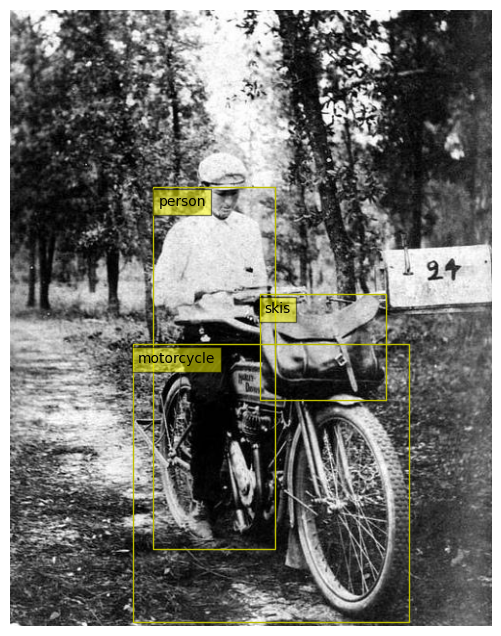

In [24]:
import sys
sys.path.append('/kaggle/input/customfasterrcnn/FasterRCNN-Torchvision-FineTuning-main')

from utils.dataset import CocoDataset
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
CDS = CocoDataset(image_folder='/kaggle/input/cococustom/kaggle/working/train',
                  annotations_file='/kaggle/input/cococustom/kaggle/working/instances_train2017.json',
                  height=640,width=500)
CDS.get_classnames()
n = CDS.get_total_classes_count()
print(n)
# For negative images
image_resized, target = CDS[36]
print(target)
image_resized, target = CDS[86]
if target['boxes'].numel() == 0:
    print('Its a negative image ..')
else:
    clss = CDS.get_classnames()
    classnames = [clss[i-1] for i in target['labels'].tolist()]

    fig, ax = plt.subplots(figsize=(8, 8))
    simg = np.transpose(image_resized.numpy(), (1, 2, 0))
    ax.imshow(simg)
    plt.close()
    fig, ax = CDS.display_bbox(bboxes=target['boxes'],fig=fig, ax=ax, 
                            in_format='xyxy', line_width=1, classes=classnames)
    ax.axis('off')
    display(fig)